In [8]:
import pandas as pd
import numpy as np
import random
# 画图用
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')
# 解决中文乱码问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
# 数据处理用
from sklearn.preprocessing import StandardScaler
# 构建模型用
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


In [9]:
#导入并查看前五组数据
df=pd.read_csv('weather_forecast_data.csv')
df.head()

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,rain
1,27.879734,46.489704,5.952484,4.990053,992.614190,no rain
2,25.069084,83.072843,1.371992,14.855784,1007.231620,no rain
3,23.622080,74.367758,7.050551,67.255282,982.632013,rain
4,20.591370,96.858822,4.643921,47.676444,980.825142,no rain


In [10]:
# 将Rain列转为二进制标签（1表示rain，0表示no_rain）
df['Rain'] = df['Rain'].apply(lambda x: 1 if str(x).strip().lower() == 'rain' else 0)

# 特征与目标
features = ['Temperature', 'Humidity', 'Wind_Speed', 'Cloud_Cover', 'Pressure']
target = 'Rain'

X_raw = df[features].values.astype(np.float32)
y_raw = df[target].values.astype(np.int64)


In [11]:
# 数据集划分：70%训练集，20%验证集，10%测试集
num_samples = X_raw.shape[0]
train_size = int(num_samples * 0.7)
val_size = int(num_samples * 0.2)
test_size = num_samples - train_size - val_size

X_train_raw, y_train_raw = X_raw[:train_size], y_raw[:train_size]
X_val_raw, y_val_raw = X_raw[train_size:train_size+val_size], y_raw[train_size:train_size+val_size]
X_test_raw, y_test_raw = X_raw[train_size+val_size:], y_raw[train_size+val_size:]

# 特征标准化
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_raw)
X_val_scaled = scaler_X.transform(X_val_raw)
X_test_scaled = scaler_X.transform(X_test_raw)

# 转换为PyTorch张量
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train_raw, dtype=torch.long)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val = torch.tensor(y_val_raw, dtype=torch.long)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test_raw, dtype=torch.long)

# 创建训练数据集
train_dataset = TensorDataset(X_train, y_train)

In [12]:
#模型定义
class Logestic(nn.Module):
    def __init__(self):
        super(Logestic,self).__init__()
        self.net=nn.Sequential(
            nn.Linear(5,128),nn.ReLU(), 
            nn.Linear(128,2)
        )
        #初始化参数
        nn.init.kaiming_normal_(self.net[0].weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.net[2].weight, mode='fan_in', nonlinearity='relu')
            
        
    def forward(self,x):
        y=self.net(x)
        
        return y

In [13]:
#定义主函数模型训练
def train(epochs=100,patience=10):
    # 模型实例化
    model=Logestic().to('cuda:0')
    criterion=nn.CrossEntropyLoss()
    optimizer=torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=1e-6)
    train_loader=DataLoader(dataset=train_dataset,shuffle=True,batch_size=32)
    

    train_losses=[]
    val_losses=[]

    best_val_loss=np.inf
    best_params=None
    no_improve_count=0

    model.train()
    for epoch in range(epochs):
        train_loss=0
        val_loss=0

        #训练
        for inputs,lables in train_loader:
            inputs,lables=inputs.to('cuda:0'),lables.to('cuda:0')
            outputs=model(inputs)        #计算模型输出
            loss=criterion(outputs,lables) #计算交叉熵损失函数
            train_loss+=loss.item()      #用item方法提取tensor中的数字
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss/=len(train_loader)   #计算平均损失
        train_losses.append(train_loss)

        #验证
        model.eval()
        with torch.no_grad():
                outputs=model(X_val.to('cuda:0'))
                loss=criterion(outputs,y_val.to('cuda:0'))
                val_loss+=loss.item()
                val_losses.append(val_loss)

        #更新最佳参数
        if val_loss<best_val_loss:
            best_val_loss=val_loss
            best_params=[p.data.clone() for p in model.parameters()]
            no_improve_count=0
        else:
            no_improve_count+=1
        #早停
        if no_improve_count>=patience:
            print(f"Early stopping at epoch {epoch}")
            break
        #每10个epoch打印一次
        if (epoch+1)%10==0:
            print(f"Epoch {epoch+1}/{epochs},train_loss={train_loss:.4f},val_loss={val_loss:.4f}")

    #加载最佳参数
    if best_params is not None:
        with torch.no_grad():
            for p,best_p in zip(model.parameters(),best_params):
                p.copy_(best_p)
        
    #测试
    model.eval()
    with torch.no_grad():
        outputs=model(X_test.to('cuda:0'))
        test_loss=criterion(outputs,y_test.to('cuda:0'))
        predict=torch.argmax(outputs,dim=1)
        accuracy=(predict==y_test.to('cuda:0')).float().mean().item()
    print(f"Test accuracy:{accuracy:.4f}")

    #训练集的损失曲线和测试集的准确率曲线
    plt.figure(figsize=(8,6),dpi=300)
    plt.plot(train_losses,label='train',linewidth=2)
    plt.plot(val_losses,label='test',linewidth=2)
    plt.legend(fontsize=12)
    plt.grid(True,linestyle='--',alpha=0.5)
    plt.xlabel('循环次数',fontsize=12)
    plt.ylabel('损失',fontsize=12)
    plt.title('训练集与验证集的损失曲线',fontsize=14)
    plt.tight_layout()
    plt.savefig('训练集与验证集的损失曲线.png')
    plt.show()
    plt.close()

    # 绘制混淆矩阵
    plt.figure(figsize=(8, 6),dpi=300)
    cm = confusion_matrix(y_test.cpu().numpy(), predict.cpu().numpy())
    disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no rain','rain'])
    disp.plot(cmap=plt.cm.Blues,colorbar=False)
    plt.title('测试集混淆矩阵',fontsize=16)
    plt.xlabel('预测标签',fontsize=14)
    plt.ylabel('真实标签',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.savefig('测试集混淆矩阵.png')
    plt.show()
    plt.close()
    return test_loss,accuracy
            
        

Epoch 10/100,train_loss=0.0277,val_loss=0.0249
Epoch 20/100,train_loss=0.0095,val_loss=0.0145
Epoch 30/100,train_loss=0.0077,val_loss=0.0117
Epoch 40/100,train_loss=0.0056,val_loss=0.0067
Early stopping at epoch 46
Test accuracy:0.9920


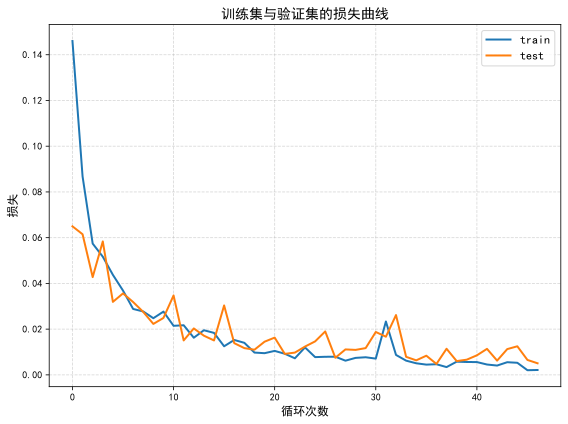

<Figure size 2400x1800 with 0 Axes>

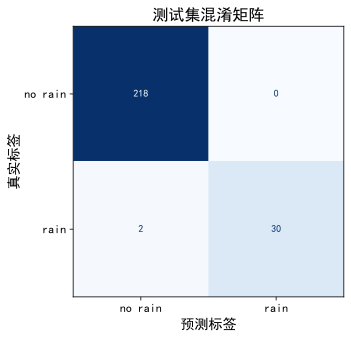

最终的测试集损失为： tensor(0.0156, device='cuda:0') 准确率为： 0.9920000433921814


In [14]:
#训练
test_loss,accuracy=train()
print('最终的测试集损失为：',test_loss,'准确率为：',accuracy)